## download do dataset e dependências

In [ ]:
!wget https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-cls.pt


In [7]:
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git

fatal: destination path 'InfraredSolarModules' already exists and is not an empty directory.


In [ ]:
!unzip /content/InfraredSolarModules/2020-02-14_InfraredSolarModules.zip -d InfraredSolarModules

In [ ]:
!pip install ultralytics scikit-learn pandas

In [10]:
#imports
import ultralytics
from ultralytics import YOLO
import torch
import torchvision
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
# Definir paths
root = "/content/InfraredSolarModules/InfraredSolarModules"
json_path = os.path.join(root, "module_metadata.json")
images_dir = os.path.join(root, "images")

# Ler o JSON com labels
with open(json_path, "r") as f:
    metadata = json.load(f)

# Criar estrutura do dataset YOLO
base = "/content/dataset"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(base, split), exist_ok=True)

# Transformar JSON em lista
data = []
for key, info in metadata.items():
    img_path = os.path.join(images_dir, os.path.basename(info["image_filepath"]))
    label = info["anomaly_class"]
    data.append((img_path, label))

print(data)

# Separar rótulos e caminhos
paths = [d[0] for d in data]
labels = [d[1] for d in data]

# Split 70/15/15
train_paths, temp_paths, train_labels, temp_labels = train_test_split(paths, labels, test_size=0.30, random_state=42, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.50, random_state=42, stratify=temp_labels)

# Função para organizar os arquivos
def move_files(paths, labels, split):
    split_dir = os.path.join(base, split)
    for path, label in zip(paths, labels):
        class_dir = os.path.join(split_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(path, class_dir)

# Executar organização
move_files(train_paths, train_labels, "train")
move_files(val_paths, val_labels, "val")
move_files(test_paths, test_labels, "test")

print("Dataset criado!")


[('/content/InfraredSolarModules/InfraredSolarModules/images/13357.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/13356.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/19719.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11542.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11543.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11540.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11541.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11546.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11547.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11544.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSolarModules/images/11545.jpg', 'No-Anomaly'), ('/content/InfraredSolarModules/InfraredSo

## Rede YOLOv8

In [12]:
print("Python version: ", sys.version)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
print("Ultralytics version: ", ultralytics.__version__)

Python version:  3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch version:  2.9.0+cu126
Torchvision version:  0.24.0+cu126
Ultralytics version:  8.3.235


In [13]:
#hiperparametros

data = 'dataset'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 20 # quantidade de vezes que a modelo passa pelas imagens
imgsz=64 # tamanho da imagem
dropout = 0.2 #desliga 20% dos neuronios aleatoriamente para aumentar generalização
lr0 = 0.01 # taxa de aprendizado
save_period = 10 # salvar a cada 10 epochs
seed = 42 # semente para reprodutibilidade
freeze = None # não congela as primeiras camadas do modelo para fine tuning


In [14]:
#carregar um modelo
#model = YOLO('yolo8n-cls.pt') # pretreinado
# cria um yaml com os pesos tranferidos
model = YOLO('yolov8n-cls.pt')

#treinamento
results = model.train(data=data,
											epochs=epochs,
											imgsz=imgsz,
                      device=device,
                      dropout=dropout,
                      lr0=lr0,
                      save_period=save_period,
                      seed=seed,
                      freeze=freeze)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True,


image 1/1 /content/dataset/test/Cell-Multi/3558.jpg: 64x64 No-Anomaly 0.45, Offline-Module 0.33, Cell-Multi 0.08, Cell 0.06, Diode-Multi 0.02, 7.1ms
Speed: 1.1ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /content/dataset/test/Cell-Multi/3563.jpg: 64x64 Cracking 0.51, Cell-Multi 0.37, Cell 0.05, Soiling 0.04, Shadowing 0.02, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /content/dataset/test/Cell-Multi/3564.jpg: 64x64 Cell-Multi 0.82, Cracking 0.09, Cell 0.06, Offline-Module 0.02, No-Anomaly 0.01, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /content/dataset/test/Cell-Multi/3580.jpg: 64x64 No-Anomaly 0.64, Cell 0.16, Cell-Multi 0.08, Offline-Module 0.05, Vegetation 0.03, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /content/dataset/test/Cell-M

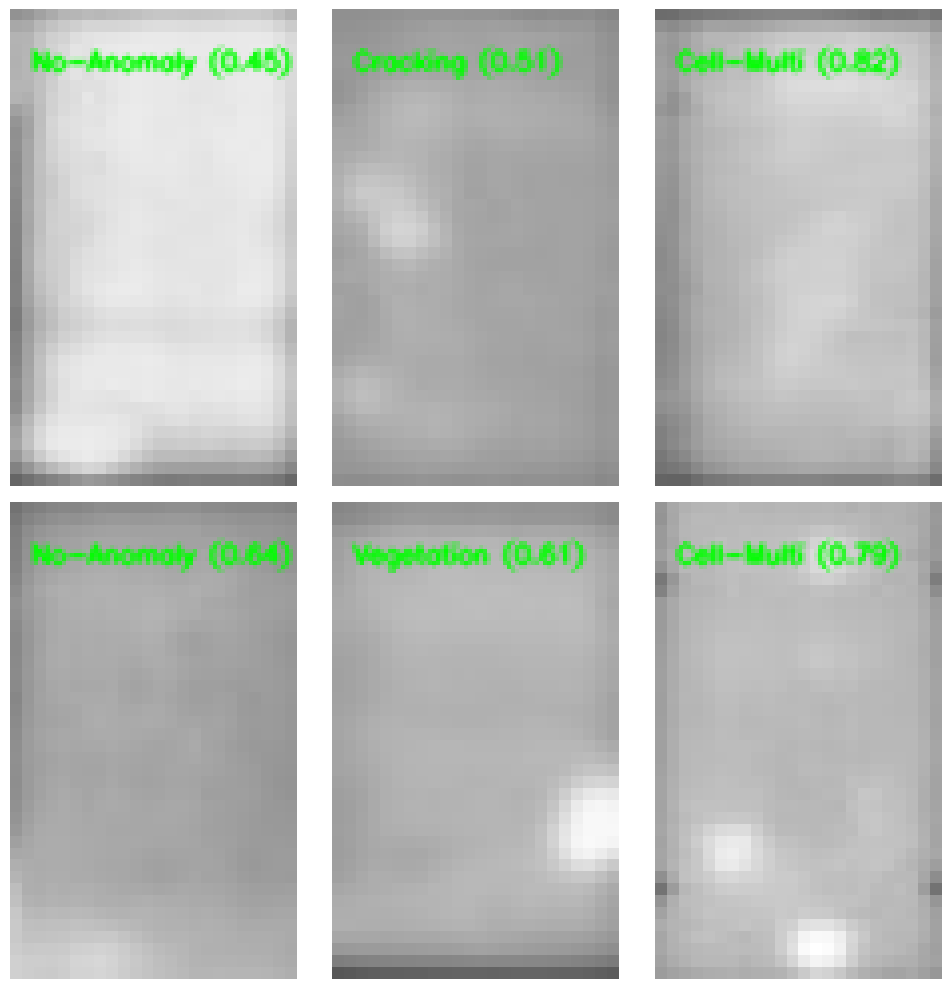

In [40]:
model = YOLO('/content/runs/classify/train/weights/best.pt')
img_paths = []
for root, _, files in os.walk("/content/dataset/test"):
  for f in files:
    if f.lower().endswith(".jpg"):
      img_paths.append(os.path.join(root, f))

img_paths = sorted(img_paths) #ordena as imagens
img_paths = img_paths[:16] #Pega ate 16 imagens

annotated_images = []

for img_path in img_paths:
  result = model(img_path)[0]

  #extraindo classe e confiança
  class_id = int(result.probs.top1)
  class_name = result.names[class_id]
  confidence = float(result.probs.top1conf)

  #carregar a imagem que passou pelo classificador
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, None, fx=3, fy=3, interpolation=cv2.INTER_NEAREST)


  #anotar a imagem
  text = f"{class_name} ({confidence:.2f})"
  cv2.putText(img, text, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
              0.21, (0, 255, 0), 1, cv2.LINE_AA)
  annotated_images.append(img)

#plot 4x4
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for ax, img in zip(axs.flatten(), annotated_images):
  ax.imshow(img)
  ax.axis("off")

plt.tight_layout()
plt.show()


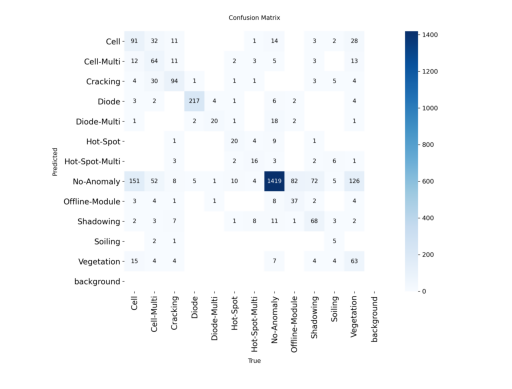

In [42]:
# Matriz de confusão
img = cv2.imread("/content/runs/classify/train/confusion_matrix.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # converte para RGB

plt.imshow(img)
plt.axis("off")  # remove eixos
plt.show()

In [41]:
# Métricas
def precision(tp,fp):
    #porcentagem de verdadeiros reais
    return tp/(tp + fp)  if (tp + fp) > 0 else 0

def recall(tp,fn):
    #porcentagem de verdadeiros reais encontrados
    return tp/(tp + fn) if (tp + fn) > 0 else 0

def f1_score(precision, recall):
    #garante o equilibrio entre precision e recall
    #está encontrando todos os verdadeiros e não apontando falsos verdadeiros
    return 2*precision*recall/(precision+recall) if (precision + recall) > 0 else 0

def micro_average(tp: dict, fp: dict, fn: dict):
    # considera o desempenho global do modelo
    tp_total = sum(tp.values())
    fp_total = sum(fp.values())
    fn_total = sum(fn.values())

    precision_micro_avg = precision(tp_total,fp_total)
    recall_micro_avg = recall(tp_total,fn_total)
    f1_micro_avg = f1_score(precision_micro_avg, recall_micro_avg)

    print(f"Precisão (micro-averaging) = {round(precision_micro_avg, 4)}")
    print(f"Recall (micro-averaging) = {round(recall_micro_avg, 4)}")
    print(f"F1-score (micro-averaging) = {round(f1_micro_avg, 4)}")

def macro_average(tp: dict, fp: dict, fn: dict):
    #considera as metricas individualmente e depois entrega a média
    #permite visualizar o desempenho individual das classes

    n_classes = 0
    precision_sum = 0
    recall_sum = 0
    f1_score_sum = 0

    for classe in tp.keys():
        precision_classe = precision(tp[classe], fp[classe])
        recall_classe = recall(tp[classe],fn[classe])
        f1_score_classe = f1_score(precision_classe,recall_classe)
        precision_sum += precision_classe
        recall_sum += recall_classe
        f1_score_sum += f1_score_classe
        n_classes += 1

    precision_macro_avg = precision_sum / n_classes
    recall_macro_avg = recall_sum / n_classes
    f1_macro_avg = f1_score_sum / n_classes

    print(f"Precisão (macro-averaging) = {round(precision_macro_avg, 4)}")
    print(f"Recall (macro-averaging) = {round(recall_macro_avg, 4)}")
    print(f"F1-score (macro-averaging) = {round(f1_macro_avg, 4)}")


def metrics_calculate(model_pt):

    model = YOLO(model_pt) #model = "path/to/model.pt"
    metrics = model.val()

    conf_matrix = metrics.confusion_matrix.matrix #Matriz bruta (np_array)
    names = model.names #Dicicionario: indice -> nome da classe
    print("Matriz de Confusão:")
    print(conf_matrix)

    #Calcula TP, FP, TN, FN automaticamente e armazena em dicionários
    tp, fp, fn, tn = {},{},{},{}
    for i, classe in names.items():
        tp[classe] = conf_matrix[i,i]
        fn[classe] = np.sum(conf_matrix[:,i]) - tp[classe]
        fp[classe] = np.sum(conf_matrix[i, :]) - tp[classe]
        tn[classe] = np.sum(conf_matrix) - (tp[classe] + fp[classe] + fn[classe])

        print(f"{classe}: TP={tp[classe]} | FP={fp[classe]} | FN={fn[classe]} | TN={tn[classe]}")

    micro_average(tp,fp,fn)
    macro_average(tp,fp,fn)

model_pt = '/content/runs/classify/train/weights/best.pt'
metrics_calculate(model_pt)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,450,252 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 14000 images in 12 classes ✅ 
val: /content/dataset/val... found 3000 images in 12 classes ✅ 
test: /content/dataset/test... found 3000 images in 12 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 37.0±14.4 MB/s, size: 0.5 KB)
val: Scanning /content/dataset/val... 3000 images, 0 corrupt: 100% ━━━━━━━━━━━━ 3000/3000 4.3Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 188/188 77.6it/s 2.4s
                   all      0.706      0.974
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
Matriz de Confusão:
[[         90          33          11           0           0           0           1          13           0           3           2          28           0]
 [         1